### This notebook is to obtain the pseudo cls of a maps created by the cls

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp

In [3]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower

In [4]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()

pars.set_cosmology(H0=70, ombh2=0.019, omch2=0.122, mnu=0.06, omk=0.05, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [5]:
#calculate results for these parameters
results = camb.get_results(pars)

In [6]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

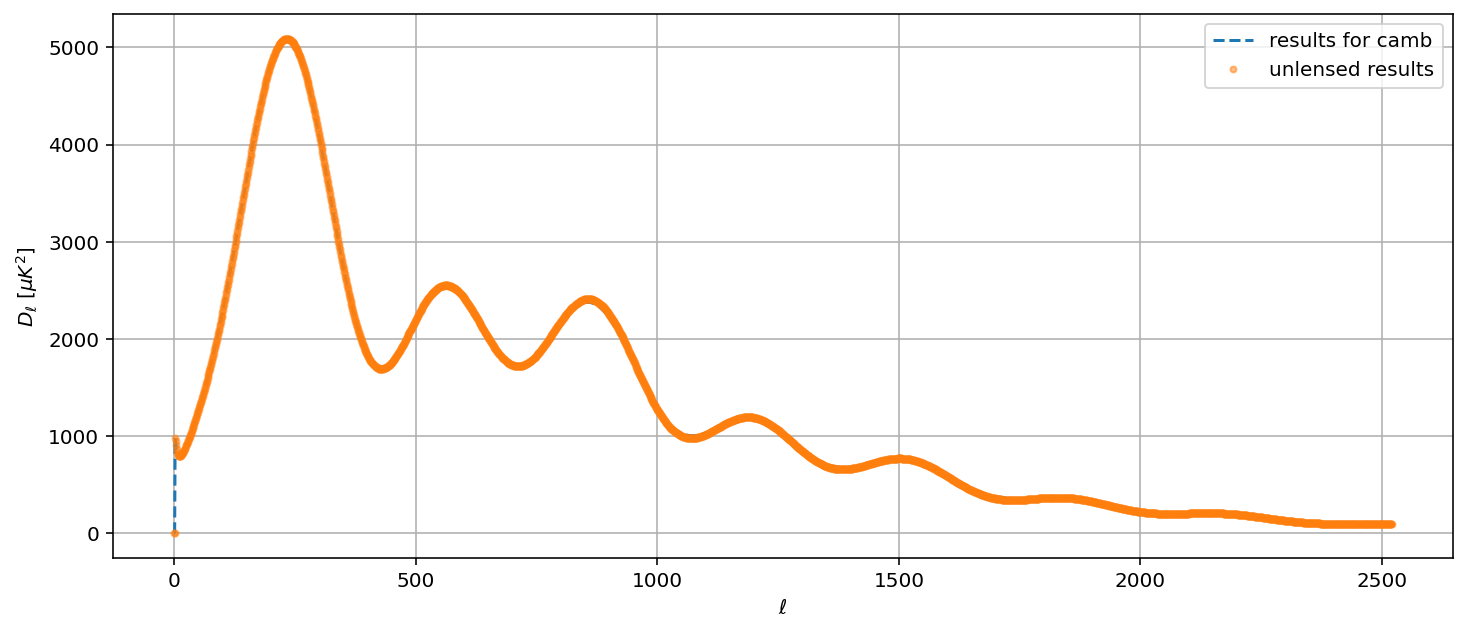

In [7]:
#plot the total lensed CMB power spectra 
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
ls = np.arange(totCL.shape[0])
plt.figure(figsize=(12, 5))
plt.plot(ls, totCL[:,0], '--', alpha = 1, label='results for camb')
plt.plot(ls, unlensedCL[:,0], '.', alpha = 0.5, label ='unlensed results')
plt.xlabel(r'$\ell$')
plt.ylabel(r"$D_\ell~[\mu K^2]$")
plt.legend()
plt.grid()
plt.savefig('example1.png')

### Creating the map

In [9]:
NSIDE = 64  #which is generally a power of 2.



print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 64 is 0.92 deg


In [10]:
?hp.sphtfunc.synfast

In [11]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

49152


maps=hp.sphtfunc.synfast(totCL[:,0], NSIDE=64, lmax=221, mmax=None, alm=False, pol=True)
hp.pixelfunc.nside2resol(64, arcmin = True)
NPIX = hp.nside2npix(64)
print(NPIX)

cmb = [maps]
cmb_map=np.array(cmb)
cmb_map.ndim

print(type(cmb_map))

In [11]:
maps=hp.sphtfunc.synfast(totCL[:,0], nside=64, lmax=221, mmax=None, alm=False, pol=True)
hp.pixelfunc.nside2resol(64, arcmin = True)
NPIX = hp.nside2npix(64)
print(NPIX)

cmb = [maps]
cmb_map=np.array(cmb)
cmb_map.ndim

print(type(cmb_map))

49152
<class 'numpy.ndarray'>


In [28]:
? hp.mollview

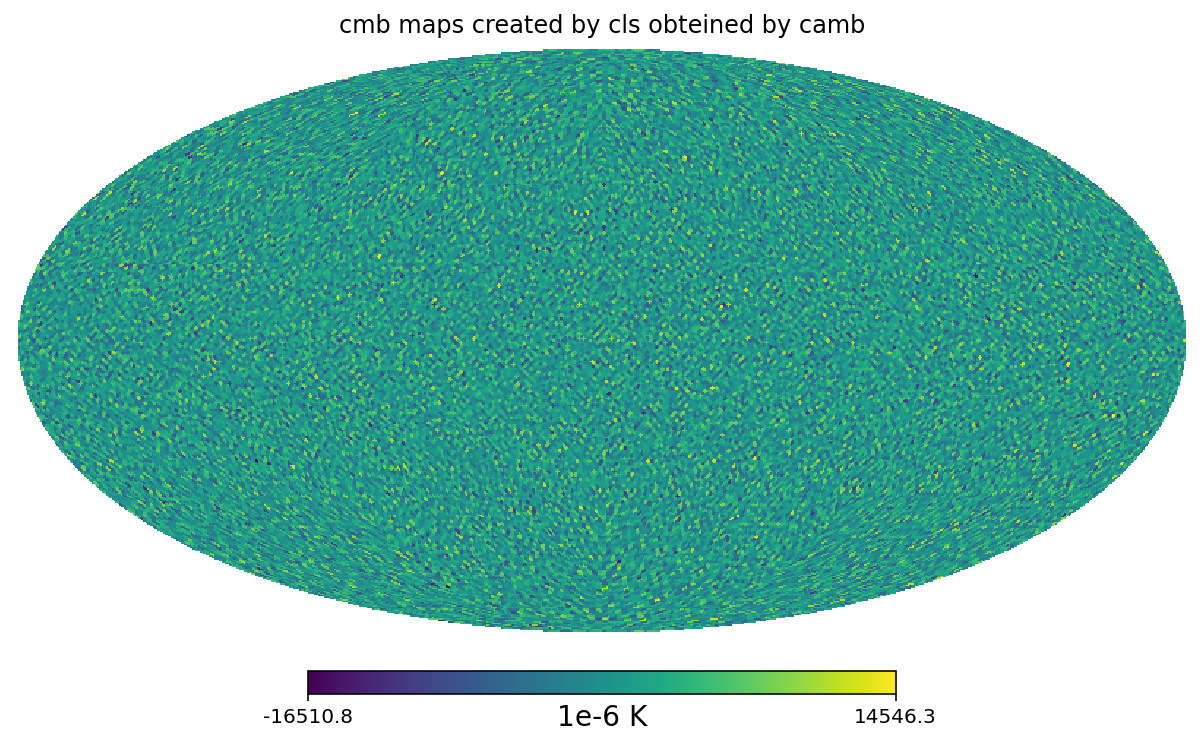

In [12]:
hp.mollview(maps, title = 'cmb maps created by cls obteined by camb', unit = '1e-6 K')

In [14]:
LMAX = 221
cl = hp.anafast(maps, lmax=LMAX)
ell = np.arange(len(cl))
ell.shape

(222,)

In [24]:
?hp.anafast
k2muK = 1e6

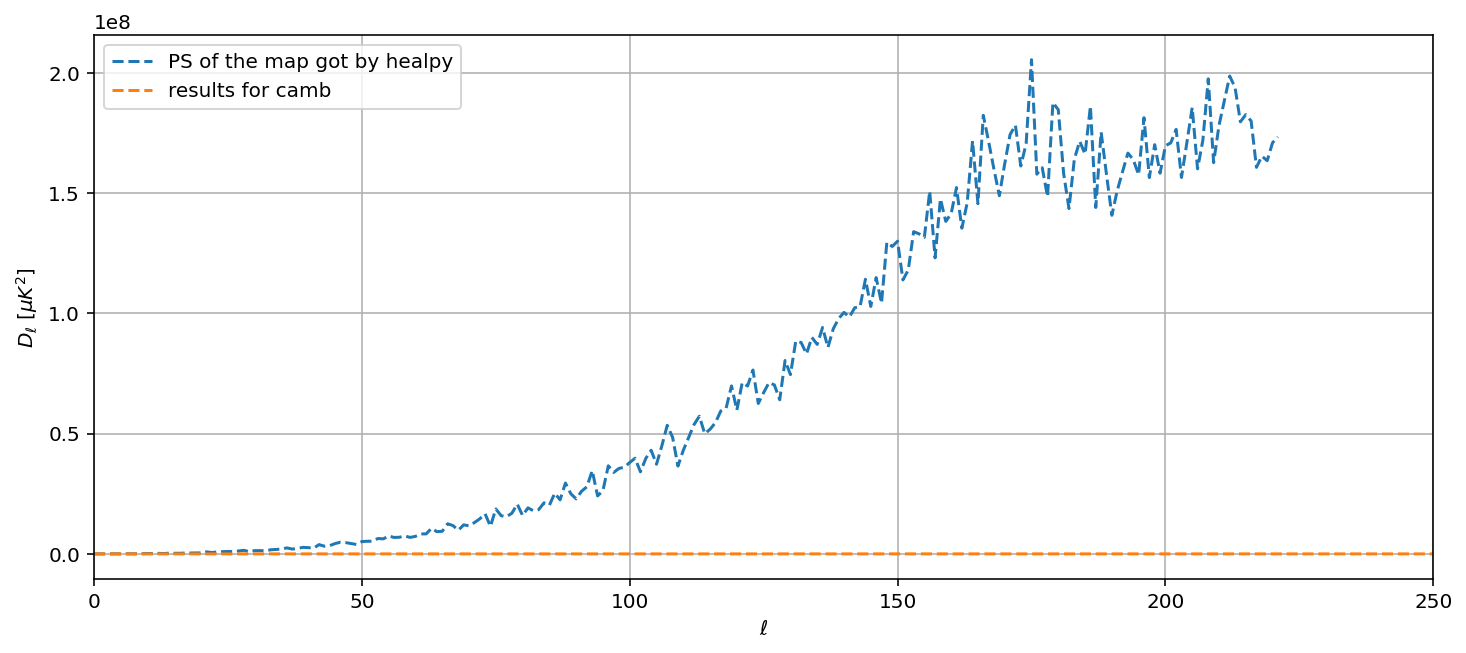

In [23]:
plt.figure(figsize=(12, 5))
y = cl*ell*(ell + 1)/2*np.pi 
plt.plot(ell, y , '--',alpha=1.0, label='PS of the map got by healpy')
plt.plot(ls, totCL[:,0], '--', alpha = 1, label='results for camb')
plt.xlim(0, 250)
plt.xlabel(r'$\ell$')
plt.ylabel(r"$D_\ell~[\mu K^2]$")
plt.legend()
plt.grid()
plt.savefig('comparaciones de PS obtenido por camb y healpy.png')

### Creating the mask with healpy

0.0 180.0 -180.0 180.0


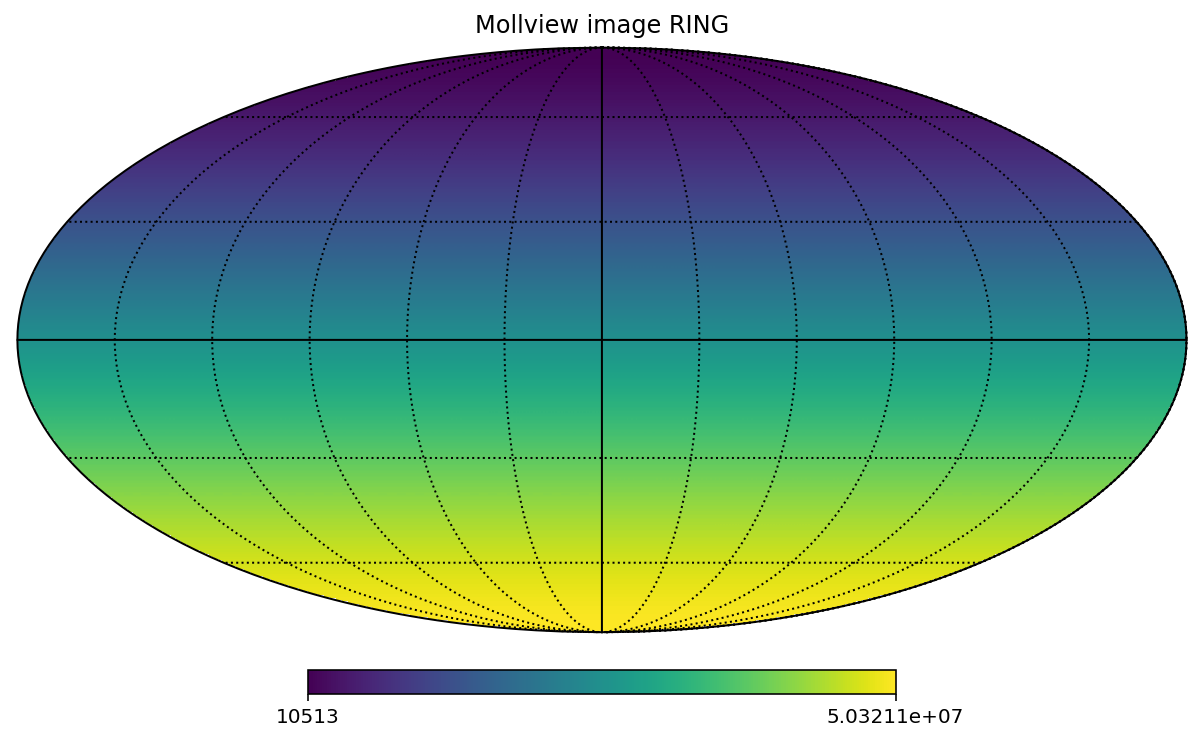

In [79]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [80]:
vec = hp.ang2vec(0, np.pi/2)
print(vec)

[0. 0. 1.]


In [11]:
map_out=hp.pixelfunc.ud_grade(map_in, 64,)

NameError: name 'map_in' is not defined

In [81]:
ipix_disc = hp.query_disc(nside=2048, vec=vec, radius=np.radians(100))

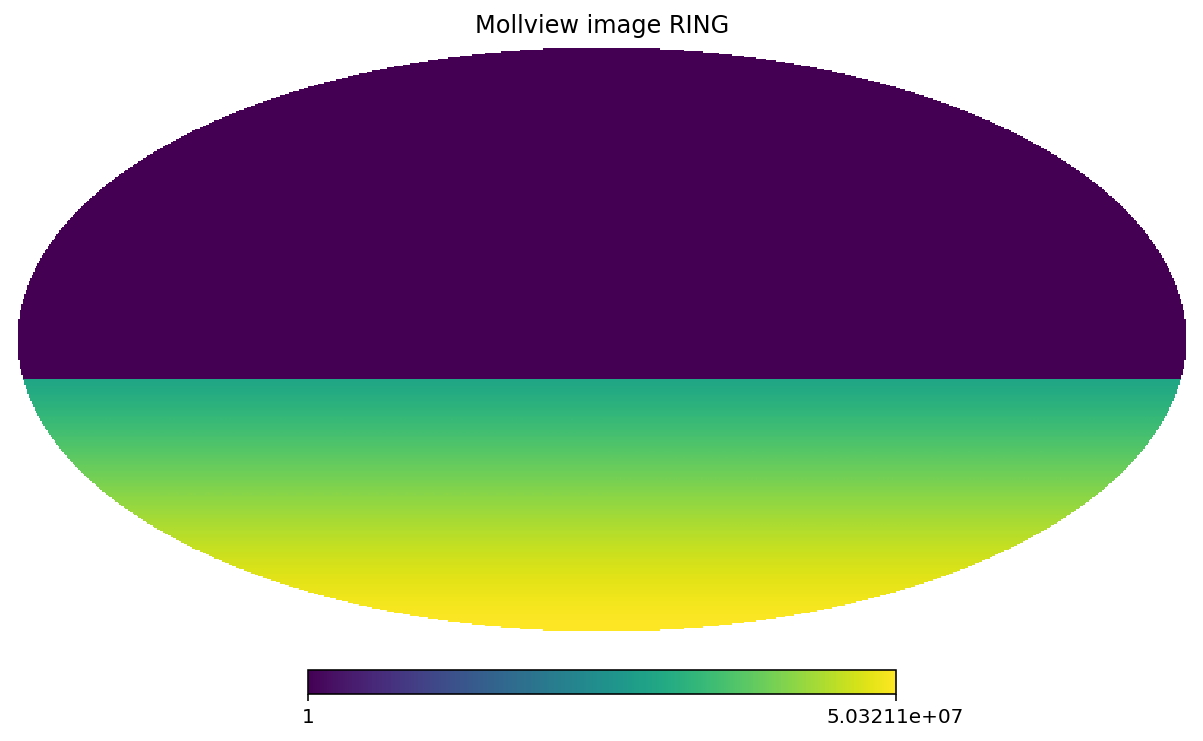

In [98]:
m = np.arange(NPIX)
m[ipix_disc] = 1
hp.mollview(m, title="Mollview image RING")

In [38]:
hp.mollview(map_out, title = 'mask created by healpy', unit= '1e-6K')

NameError: name 'map_out' is not defined

In [39]:
resolution

NameError: name 'resolution' is not defined

#### converting the mask to a fis file

In [ ]:
hp.fitsfunc.write_map(mask, maps)

In [ ]:
from astropy.io import fits

### We create a PrimaryHDU object to encapsulate the data:

In [ ]:
hdu = fits.PrimaryHDU(maps)

### We then create an HDUlist to contain the newly created primary HDU, and write to a new file

In [ ]:
hdu1 = fits.HDUList([hdu])
hdu1 = hdu1.writeto('maps.fits')


In [ ]:
hdu2 = fits.PrimaryHDU(m)

In [ ]:
hdu3 = fits.HDUList([hdu2])
hdu3 = hdu1.writeto('m.fits')

### To calculate the pseudo cls with namaster

In [83]:
# Import the NaMaster python wrapper
import pymaster as nmt

In [84]:
nside = 2048

In [14]:
# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(mask,
                            1., apotype="Smooth")

NameError: name 'mask' is not defined

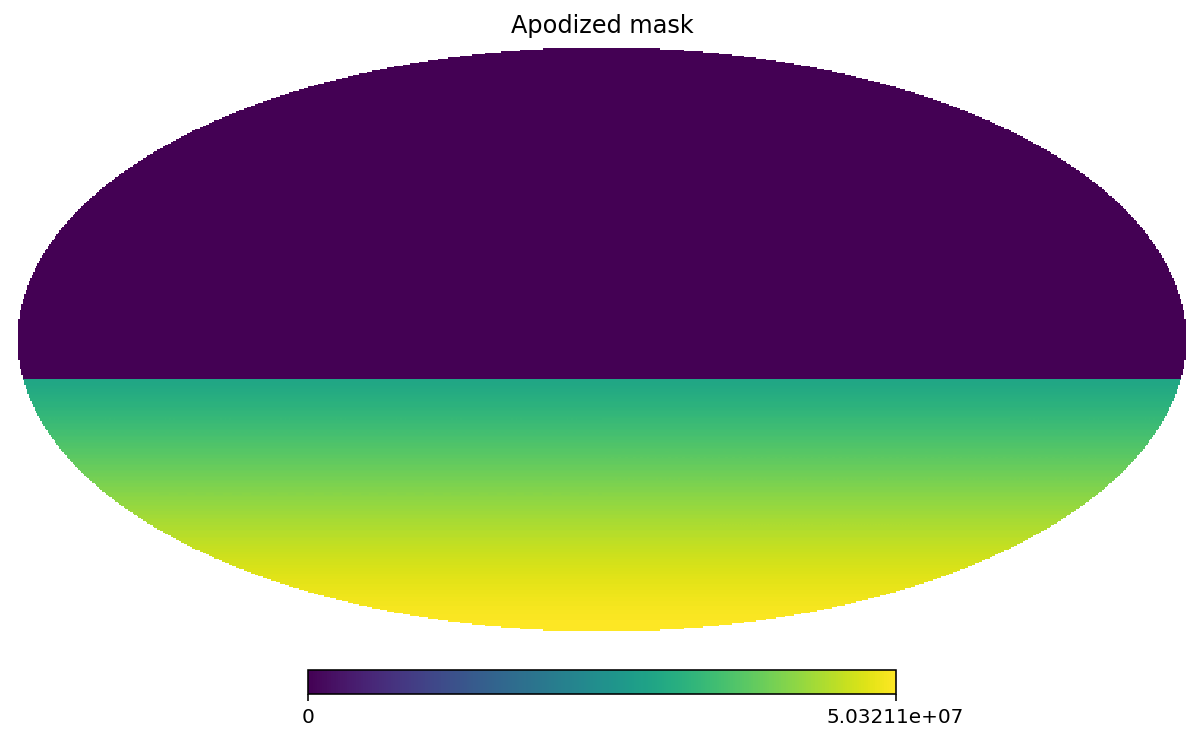

array([[-142.38614781, -143.14860563, -139.71030492, ...,  439.47537166,
         443.3304055 ,  445.67144206]])

In [85]:
hp.mollview(m, title='Apodized mask')
plt.show()
cmb_map

In [88]:
# Read healpix maps and initialize a spin-0 
f_0 = nmt.NmtField(m,[ cmb_map[0] ])

In [28]:
#? nmt.NmtField


In [89]:
# Initialize binning scheme with 4 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 4)

### Compute MASTER estimator
### spin-0 x spin-0 

In [48]:
? nmt.compute_full_master #manual

In [49]:
? nmt.NmtBin.from_nside_linear

In [51]:
?b.get_effective_ells

In [90]:
cl_00 = nmt.compute_full_master(f_0, f_0, b)

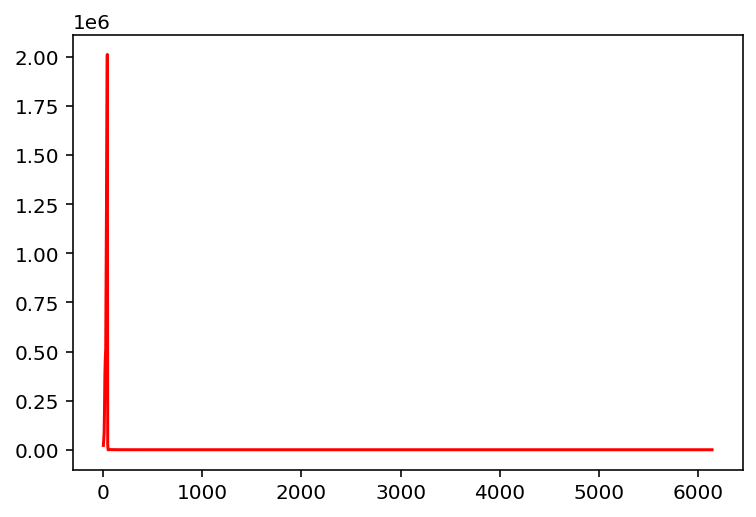

In [91]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_00[0]*ell_arr*(ell_arr +1), 'r-')
plt.savefig('PSprimeramascara.png')

In [65]:
maps=hp.sphtfunc.synfast(totCL[:,0], nside=2048, lmax=45, mmax=None, alm=False, pol=True)
hp.pixelfunc.nside2resol(2048, arcmin = True)
NPIX = hp.nside2npix(2048)
print(NPIX)

cmb = [maps] #list
cmb_map=np.array(cmb)
cmb_map.ndim

print(type(cmb_map))

50331648
<class 'numpy.ndarray'>


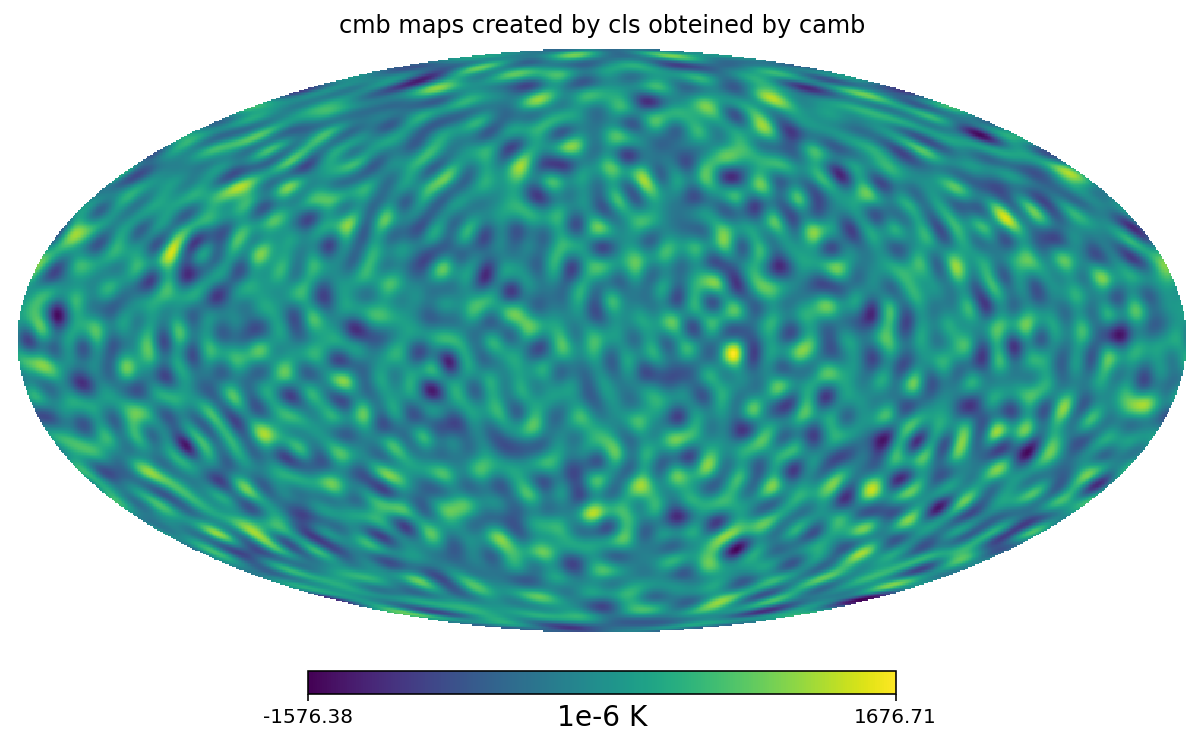

In [66]:
hp.mollview(maps, title = 'cmb maps created by cls obteined by camb', unit = '1e-6 K')

0.0 180.0 -180.0 180.0


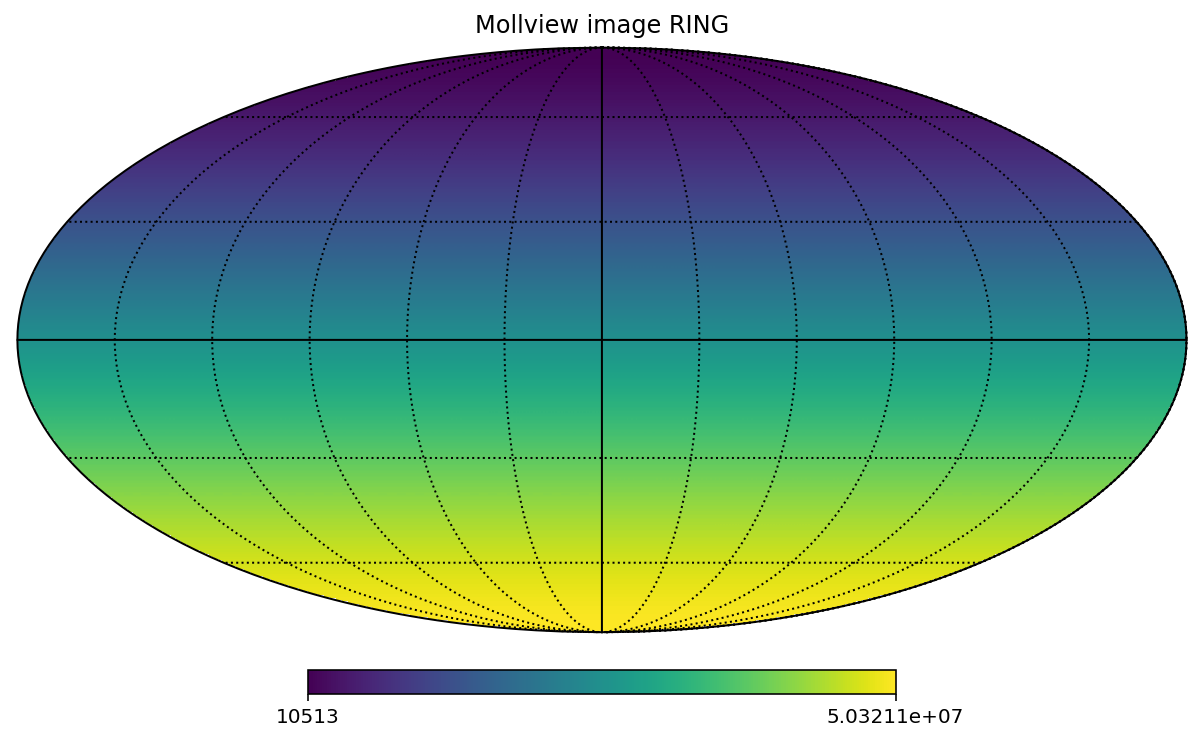

In [67]:
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [69]:
ipix_disc = hp.query_disc(nside=2048, vec=vec, radius=np.radians(100))

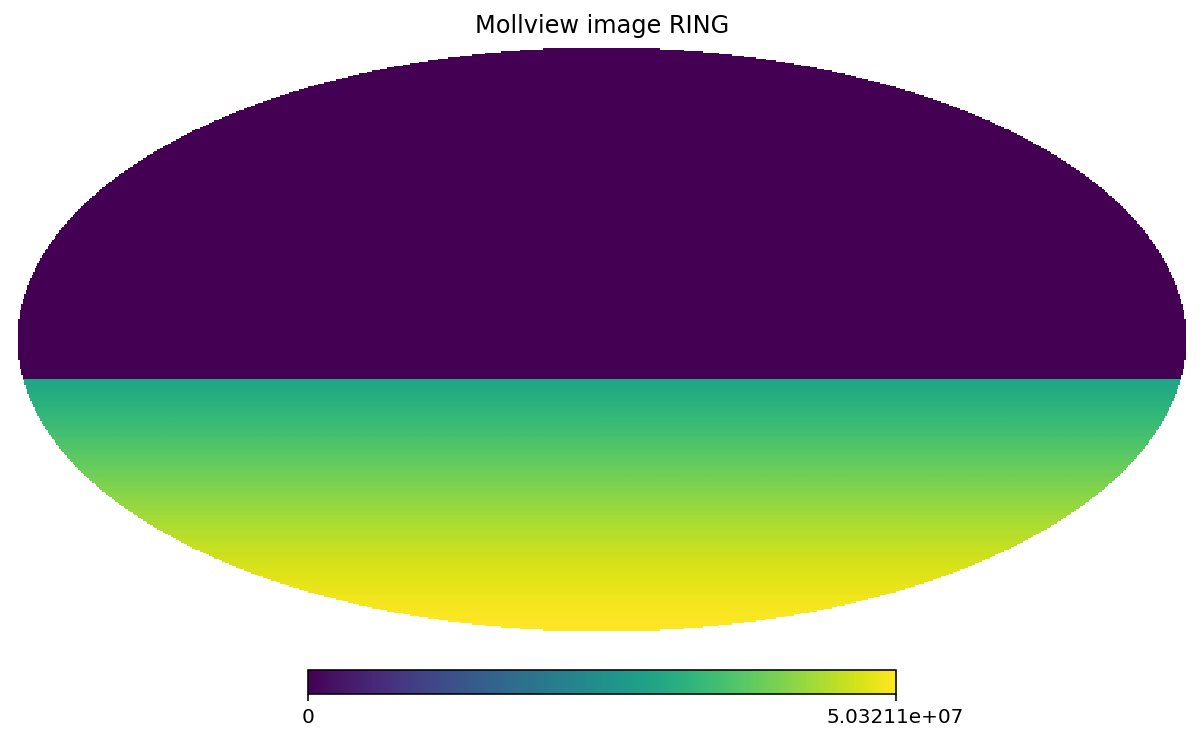

In [70]:
m = np.arange(NPIX)
m[ipix_disc] = 0
hp.mollview(m, title="Mollview image RING")

In [71]:
# Import the NaMaster python wrapper
import pymaster as nmt

In [72]:
nside = 2048

In [73]:
f_0 = nmt.NmtField(m,[ cmb_map[1] ])

IndexError: index 1 is out of bounds for axis 0 with size 1